In [1]:
import copy
import random as rnd
import math
import numpy as np
import matplotlib.pyplot as plt

# A simulation of immune and cancer cell populations

We have three types of cells that we want to track in the simulation:
- Type 1 T-cells, which can recognise cancer cells, and start an immune reaction and kill cancer cells
- Type 2 T-cells, which cannot recognise cancer cells
- Cancer cells


The reactions that could happen in each time-step:
- A T-cell (type 1 or type 2) divides to make one extra cell of the same type
- A T-cell (type 1 or type 2) dies/exits the area we are interested in
- A cancer cell divides to make one extra cancer cell
- A T-cell (of type 1) kills a cancer cell

In [2]:
# Mathematically, the different reactions are captured by reaction rates or reaction propensities
# This function defines the "probability" of each reaction occurring, given the number of each cell type and reaction parameters
def reaction_propensities(pop, params):
    r0 = params[0]*pop[0] # type 1 T-cell divides
    r1 = params[0]*pop[1] # type 2 T-cell divides
    r2 = params[1]*pop[0] # type 1 T-cell dies/leaves
    r3 = params[1]*pop[1] # type 2 T-cell dies/leaves
    r4 = params[2]*pop[2] # cancer cell divides
    r5 = params[3]*pop[2]*pop[0] # T-cell kills cancer cell
    
    return([r0,r1,r2,r3,r4,r5])

## Let's first do a single simulation step


In [3]:
# Define the number of cells we are starting with and some parameters for the reactions
starting_population = np.array([100, 100, 20]) # number of type1 T, type2 T, cancer cells
parameters = [0.5, 0.5, 3.0, 0.1] #T-cell division rate, T-cell death rate, cancer cell division rate, T-cell killing rate

We want to have exactly one reaction happening in each simulation step.

First, we compute the "probability" of each reaction happening right now. E.g. cancer cell killing (last in the list) is 4x more likely than T-cell division (first in the list)

Then, we define how much time passed until this one reaction occurred - this is how much the time changes in this one simulation step. It is not constant (e.g. 1), it depends on the summed "probability" of all the reactions: the higher the sum, the smaller time it will take for something to happen.

In [4]:
reactions_now = reaction_propensities(starting_population, parameters)
print('Reaction propensities:',reactions_now)
reactions_total = sum(reactions_now)

dtime = rnd.expovariate(reactions_total) # this is the standard formula for computing the time, you can just use this all the time
print('Time elapsed until next reaction:',dtime)

Reaction propensities: [50.0, 50.0, 50.0, 50.0, 60.0, 200.0]
Time elapsed until next reaction: 0.0006467294664021673


Then, we need to decide which reaction should occur, in a random manner that reflects these probabilities. Luckily, python has a function in the random module, called "choices" that can do just that for us: pick randomly which reaction occurs next, taking into account that these reactions have different "weights".

In [5]:
rReact = rnd.choices(range(len(reactions_now)), weights=reactions_now)[0] # we pick the index of the reaction to occur
print(rReact)

2


We have two ways of computing which reaction this indicates and how the cell populations change:
- we can go through the number line reaction-by-reaction, and write a rule of what happens if that reaction is selected

In [6]:
population = copy.copy(starting_population) # start from a copy of the starting cell numbers that we defined above

print('Population before: ', population)

if rReact==0: # first reaction means type 1 T-cell division
    population[0] = population[0] + 1 # the number of type1 T-cells increases by 1
    
if rReact==1: # second reaction, so type 2 T-cell division
    population[1] = population[1] + 1 # the number of type2 T-cells increases by 1
    
if rReact==2: # third reaction
    population[0] = population[0] - 1 # the number of type1 T-cells decreases by 1
    
if rReact==3:
    population[1] = population[1] - 1 # the number of type2 T-cells decreases by 1
    
if rReact==4:
    population[2] = population[2] + 1 # the number of cancer cells increases by 1

if rReact==5: #this is the last interval, corresponding to T-cell killing
    population[2] = population[2] - 1 # the number of cancer cells decreases by 1 due to T-cell killing them
    
print('Population after: ', population)


Population before:  [100 100  20]
Population after:  [ 99 100  20]


- We can make a faster way that is more flexible (and needs less typing) using some maths tricks:
    - we also make a matrix that defines for each reaction and each cell type, how much that cell-type changes in that reaction. E.g. second reaction (type2 T-cell division) means: +0 type1, +1 type2, +0 cancer cells

In [7]:
changes_per_reaction = np.array([[1, 0, 0], # first reaction: +1 type1, +0 type2, +0 cancer cells
                                 [0, 1, 0], # second reaction: +0 type1, +1 type2, +0 cancer cells
                                 [-1, 0, 0],
                                 [0, -1, 0],
                                 [0, 0, 1],
                                 [0, 0, -1]]) # last reaction: +0 type1, +0 type2, -1 cancer cells 

In [8]:
population = copy.copy(starting_population) # start from a copy of the starting cell numbers that we defined above

print('Population before: ', population)

# we can change the numbers of cell populations using the row of changes_per_reaction that rReact selects for us
population = population + changes_per_reaction[rReact,:]

print('Population after: ', population)
print('This should be the same as above!')

Population before:  [100 100  20]
Population after:  [ 99 100  20]
This should be the same as above!


## Now let's put it all together and make a simulation from top

We'll start with defining the model e.g. what kind of cells are in it and what reactions happen in it
- This is something that we think is general about the system, it should be the same for all people/tumours/etc.

Then we define the starting values and parameters
- This is something that could be different between people/tumours or experiments
- We can make simulated experiments where we change these values. E.g. changing the last parameter would correspond to "T-cells becoming more active against cancer"; changing tMax represents running a longer simulation/experiment

Then we run the simulation
- This takes the values we just defined, so nothing has to be re-written in it, we can simply re-run if we change e.g. the parameters

Then we have a complete simulation run, which we can analyse, for example by plotting how the different cell types gained new cells or lost cells over time

In [9]:
# Define the reaction propensity function and change matrix that describes the reactions that can occur

def reaction_propensities(pop, params):
    r0 = params[0]*pop[0] # type 1 T-cell divides
    r1 = params[0]*pop[1] # type 2 T-cell divides
    r2 = params[1]*pop[0] # type 1 T-cell dies/leaves
    r3 = params[1]*pop[1] # type 2 T-cell dies/leaves
    r4 = params[2]*pop[2] # cancer cell divides
    r5 = params[3]*pop[2]*pop[0] # T-cell kills cancer cell
    
    return([r0,r1,r2,r3,r4,r5])

changes_per_reaction = np.array([[1, 0, 0], # first reaction: +1 type1, +0 type2, +0 cancer cells
                                 [0, 1, 0], # second reaction: +0 type1, +1 type2, +0 cancer cells
                                 [-1, 0, 0],
                                 [0, -1, 0],
                                 [0, 0, 1],
                                 [0, 0, -1]]) # last reaction: +0 type1, +0 type2, -1 cancer cells 

In [24]:
# Define the starting numbers of cells and parameters about the reactions

starting_population = np.array([100, 100, 20]) # number of type1 T, type2 T, cancer cells
t = 0.0 # starting time
parameters = [0.5, 0.5, 2.0, 0.01] #T-cell division rate, T-cell death rate, cancer cell division rate, T-cell killing rate
tMax = 2.0 # the end point until which we want to simulate, e.g. the final time

In [25]:
# Make a loop that does the single simulation step until we reach the end point
# We'll use the second method because it is more concise

result_model = []

for i in range(5):
    population = starting_population
    pop_over_time = np.array(population) # store the population values over time in this
    t = 0.0
    time = np.array(t)

    while t < tMax:
        reactions_now = reaction_propensities(population, parameters) # compute reaction probabilities: this changes as population changes
        reactions_total = sum(reactions_now)

        dtime = rnd.expovariate(reactions_total) # get how much time until next reaction
        rReact = rnd.choices(range(len(reactions_now)), weights=reactions_now)[0] # get which reaction happens
        population = population + changes_per_reaction[rReact,:] # change population accordingly
    
        t = t + dtime
        time = np.append(time, t) # note down the new time
        pop_over_time = np.vstack((pop_over_time, population)) # this is the equivalent of append, but adds a new row
        
    result_model.append(pop_over_time[-1,2])

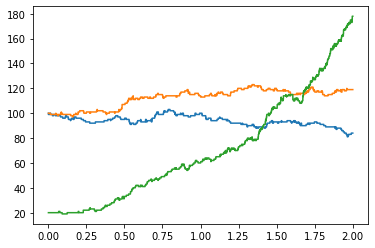

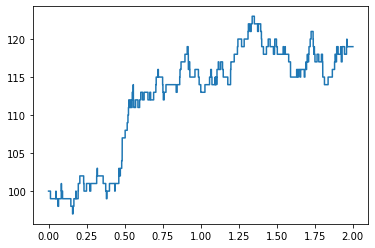

In [26]:
# We can simply plot all three cell types
plt.step(time, pop_over_time)
plt.show()

# Or we can get just one of them by selecting which column of pop_over_time, using [:,x] for column x
plt.step(time, pop_over_time[:,1]) # look at the first cell type: type1 T-cell separately
plt.show()